# Notebook 4 : Model Training and Evaluation

## Configuration de l'environnement

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Boosting libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from scikeras.wrappers import KerasRegressor

print("All libraries imported successfully!")

All libraries imported successfully!


## Parameters

In [2]:
# Set random seed for reproducibility
R_seed = 42
np.random.seed(R_seed)

# K-Fold Cross-Validation setup
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=R_seed)

print(f"Random seed: {R_seed}")
print(f"Cross-validation: {N_FOLDS}-Fold")

Random seed: 42
Cross-validation: 5-Fold


## Load Preprocessed Datasets

In [3]:
# Load Dataset 1: Linear Models
with open('../data/data_processed/dataset_linear_models.pkl', 'rb') as f:
    data_linear = pickle.load(f)
    X_train_linear = data_linear['X_train']
    X_test_linear = data_linear['X_test']
    y_train_linear = data_linear['y_train']
    y_test_linear = data_linear['y_test']

print("Dataset 1 (Linear Models) loaded:")
print(f"  Train: {X_train_linear.shape}, Test: {X_test_linear.shape}")

# Load Dataset 2: Tree-based Models
with open('../data/data_processed/dataset_tree_models.pkl', 'rb') as f:
    data_tree = pickle.load(f)
    X_train_tree = data_tree['X_train']
    X_test_tree = data_tree['X_test']
    y_train_tree = data_tree['y_train']
    y_test_tree = data_tree['y_test']

print("\nDataset 2 (Tree Models) loaded:")
print(f"  Train: {X_train_tree.shape}, Test: {X_test_tree.shape}")

# Load Dataset 3: CatBoost
with open('../data/data_processed/dataset_catboost.pkl', 'rb') as f:
    data_catboost = pickle.load(f)
    X_train_catboost = data_catboost['X_train']
    X_test_catboost = data_catboost['X_test']
    y_train_catboost = data_catboost['y_train']
    y_test_catboost = data_catboost['y_test']
    cat_features_idx = data_catboost['cat_features_idx']

print("\nDataset 3 (CatBoost) loaded:")
print(f"  Train: {X_train_catboost.shape}, Test: {X_test_catboost.shape}")
print(f"  Categorical features: {len(cat_features_idx)}")

Dataset 1 (Linear Models) loaded:
  Train: (16000, 57), Test: (4000, 57)

Dataset 2 (Tree Models) loaded:
  Train: (16000, 75), Test: (4000, 75)

Dataset 3 (CatBoost) loaded:
  Train: (16000, 67), Test: (4000, 67)
  Categorical features: 11


## Evaluation Function

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate a trained model on train and test sets.
    
    Parameters:
    -----------
    model : trained model
    X_train, y_train : training data
    X_test, y_test : test data
    model_name : str, name of the model
    
    Returns:
    --------
    dict : metrics for train and test
    """
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_R2': r2_score(y_test, y_test_pred)
    }
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*80}")
    print(f"Training Set:")
    print(f"  RMSE: {metrics['Train_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Train_MAE']:.4f}")
    print(f"  R²:   {metrics['Train_R2']:.4f}")
    print(f"\nTest Set:")
    print(f"  RMSE: {metrics['Test_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Test_MAE']:.4f}")
    print(f"  R²:   {metrics['Test_R2']:.4f}")
    print(f"{'='*80}")
    
    return metrics

# Initialize results storage
all_results = []

print("Evaluation function defined")

Evaluation function defined


---
# Model 1: Ridge Regression

Training Ridge Regression...
Fitting 5 folds for each of 77 candidates, totalling 385 fits

Best parameters: {'alpha': 0.01, 'solver': 'sparse_cg'}
Best CV RMSE: 3.4540

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

Ridge (CV) - Performance Metrics
Training Set:
  RMSE: 3.4332
  MAE:  2.6907
  R²:   0.8038

Test Set:
  RMSE: 3.6507
  MAE:  2.8106
  R²:   0.7853

--- Retraining on full training data ---

Ridge Regression - Performance Metrics
Training Set:
  RMSE: 3.4332
  MAE:  2.6907
  R²:   0.8038

Test Set:
  RMSE: 3.6507
  MAE:  2.8106
  R²:   0.7853
✓ Ridge model saved


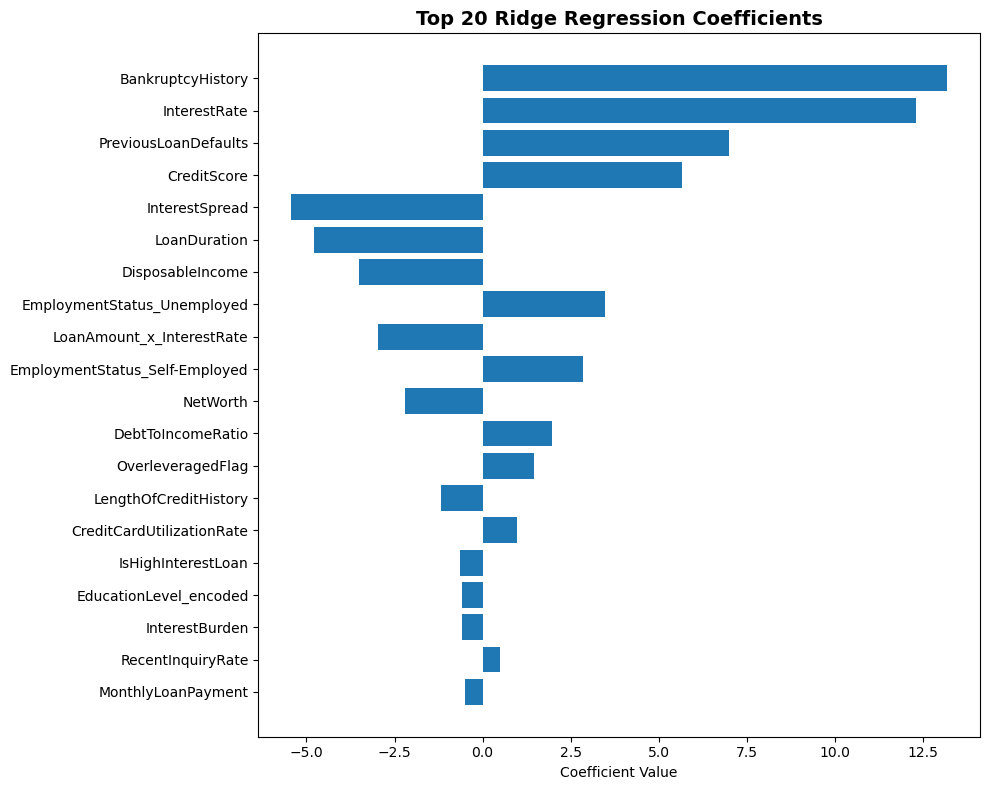

In [5]:
print("Training Ridge Regression...")

# Extensive hyperparameter grid
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge = Ridge(random_state=R_seed, max_iter=10000)
ridge_grid = GridSearchCV(
    ridge, 
    ridge_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

ridge_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {ridge_grid.best_params_}")
print(f"Best CV RMSE: {-ridge_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
ridge_cv = ridge_grid.best_estimator_
ridge_cv_metrics = evaluate_model(
    ridge_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Ridge (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
ridge_best = Ridge(**ridge_grid.best_params_, random_state=R_seed, max_iter=10000)
ridge_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
ridge_metrics = evaluate_model(
    ridge_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Ridge Regression'

)

all_results.append(ridge_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/ridge_best.pkl', 'wb') as f:
    pickle.dump(ridge_best, f)
with open('../models/ridge_gridsearch.pkl', 'wb') as f:
    pickle.dump(ridge_grid, f)
print("✓ Ridge model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

ridge_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_best.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(ridge_coef['Feature'], ridge_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Regression Coefficients', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---
# Model 2: Lasso Regression

Training Lasso Regression...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'alpha': 0.001, 'selection': 'cyclic'}
Best CV RMSE: 3.4541

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

Lasso (CV) - Performance Metrics
Training Set:
  RMSE: 3.4337
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6487
  MAE:  2.8083
  R²:   0.7856

--- Retraining on full training data ---

Lasso Regression - Performance Metrics
Training Set:
  RMSE: 3.4337
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6487
  MAE:  2.8083
  R²:   0.7856
✓ Lasso model saved

Lasso selected 55 features out of 57


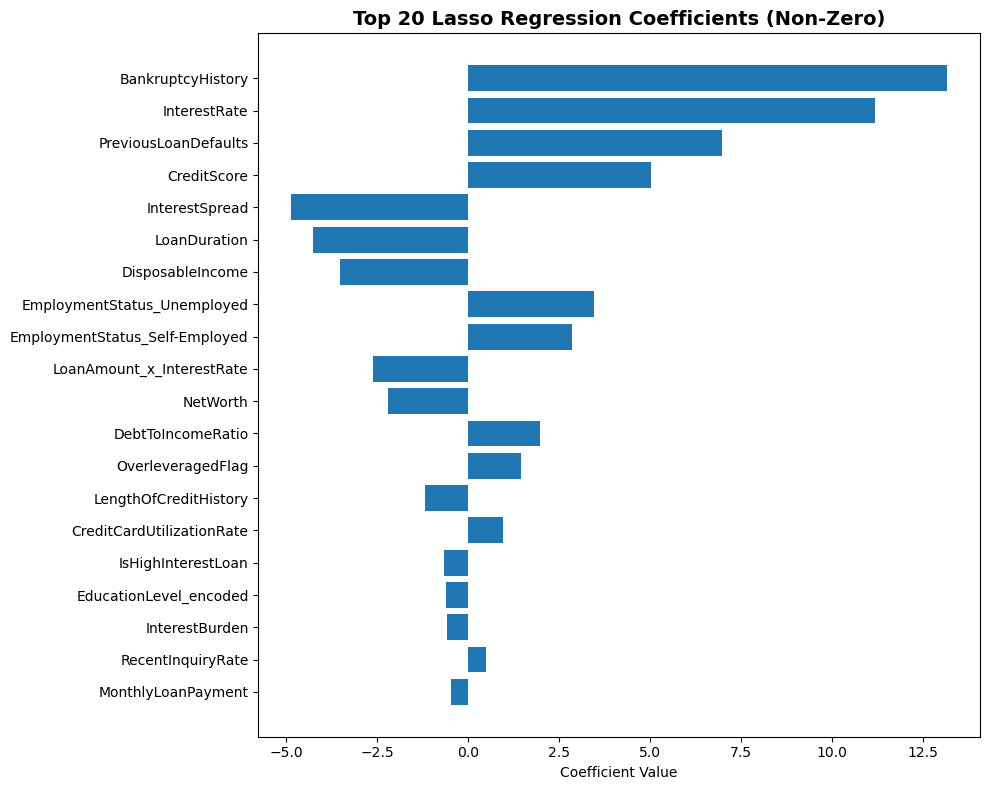

In [6]:
print("Training Lasso Regression...")

# Extensive hyperparameter grid
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
    'selection': ['cyclic', 'random']
}

lasso = Lasso(random_state=R_seed, max_iter=10000)
lasso_grid = GridSearchCV(
    lasso, 
    lasso_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

lasso_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {lasso_grid.best_params_}")
print(f"Best CV RMSE: {-lasso_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
lasso_cv = lasso_grid.best_estimator_
lasso_cv_metrics = evaluate_model(
    lasso_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Lasso (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
lasso_best = Lasso(**lasso_grid.best_params_, random_state=R_seed, max_iter=10000)
lasso_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
lasso_metrics = evaluate_model(
    lasso_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Lasso Regression'

)
all_results.append(lasso_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/lasso_best.pkl', 'wb') as f:
    pickle.dump(lasso_best, f)
with open('../models/lasso_gridsearch.pkl', 'wb') as f:
    pickle.dump(lasso_grid, f)
print("✓ Lasso model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

lasso_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_best.coef_
})
selected_features = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False).head(20)
print(f"\nLasso selected {len(lasso_coef[lasso_coef['Coefficient'] != 0])} features out of {len(lasso_coef)}")

plt.figure(figsize=(10, 8))
plt.barh(selected_features['Feature'], selected_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Lasso Regression Coefficients (Non-Zero)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
# Model 3: ElasticNet

Training ElasticNet...
Fitting 5 folds for each of 112 candidates, totalling 560 fits

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.99, 'selection': 'cyclic'}
Best CV RMSE: 3.4542

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

ElasticNet (CV) - Performance Metrics
Training Set:
  RMSE: 3.4338
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6486
  MAE:  2.8082
  R²:   0.7856

--- Retraining on full training data ---

ElasticNet - Performance Metrics
Training Set:
  RMSE: 3.4338
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6486
  MAE:  2.8082
  R²:   0.7856
✓ ElasticNet model saved

ElasticNet selected 55 features out of 57


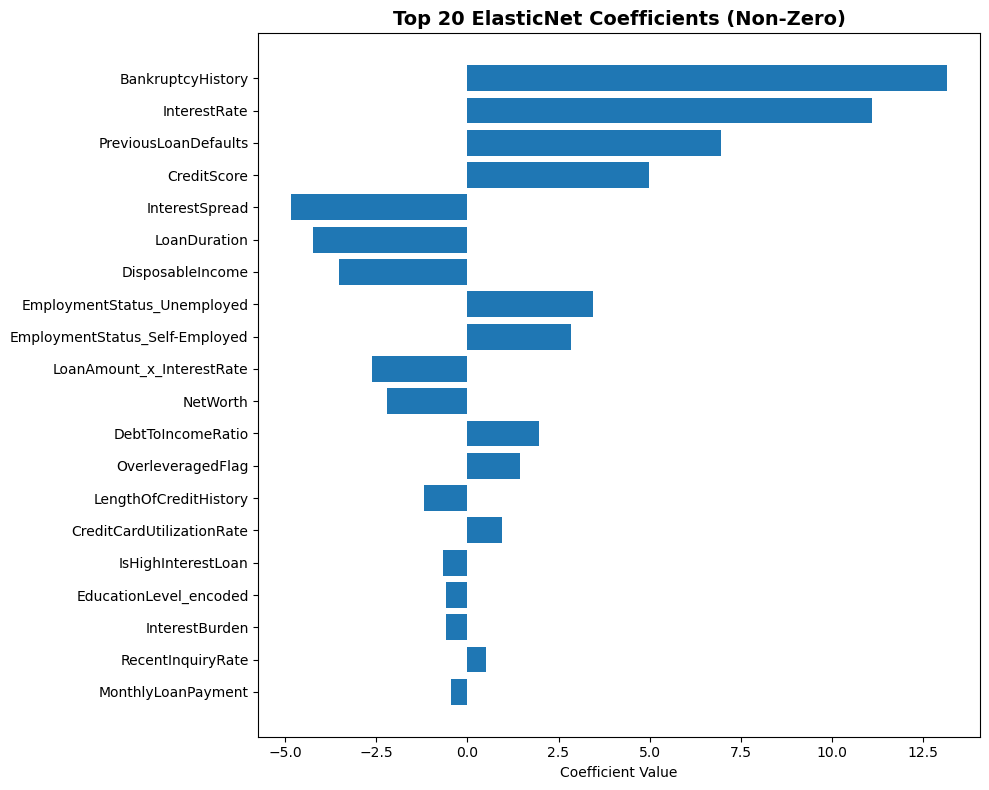

In [7]:
print("Training ElasticNet...")

# Extensive hyperparameter grid
elasticnet_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
    'selection': ['cyclic', 'random']
}

elasticnet = ElasticNet(random_state=R_seed, max_iter=10000)
elasticnet_grid = GridSearchCV(
    elasticnet, 
    elasticnet_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

elasticnet_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {elasticnet_grid.best_params_}")
print(f"Best CV RMSE: {-elasticnet_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
elasticnet_cv = elasticnet_grid.best_estimator_
elasticnet_cv_metrics = evaluate_model(
    elasticnet_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'ElasticNet (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
elasticnet_best = ElasticNet(**elasticnet_grid.best_params_, random_state=R_seed, max_iter=10000)
elasticnet_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
elasticnet_metrics = evaluate_model(
    elasticnet_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'ElasticNet'

)
all_results.append(elasticnet_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/elasticnet_best.pkl', 'wb') as f:
    pickle.dump(elasticnet_best, f)
with open('../models/elasticnet_gridsearch.pkl', 'wb') as f:
    pickle.dump(elasticnet_grid, f)
print("✓ ElasticNet model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

elasticnet_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elasticnet_best.coef_
})
selected_features = elasticnet_coef[elasticnet_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False).head(20)
print(f"\nElasticNet selected {len(elasticnet_coef[elasticnet_coef['Coefficient'] != 0])} features out of {len(elasticnet_coef)}")

plt.figure(figsize=(10, 8))
plt.barh(selected_features['Feature'], selected_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 ElasticNet Coefficients (Non-Zero)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
# Model 4: Random Forest

Training Random Forest Regressor...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV RMSE: 3.2242

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

Random Forest (CV) - Performance Metrics
Training Set:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   1.0000

Test Set:
  RMSE: 3.2527
  MAE:  2.2860
  R²:   0.8296

--- Retraining on full training data ---

Random Forest - Performance Metrics
Training Set:
  RMSE: 0.0000
  MAE:  0.0000
  R²:   1.0000

Test Set:
  RMSE: 3.2527
  MAE:  2.2860
  R²:   0.8296
✓ Random Forest model saved


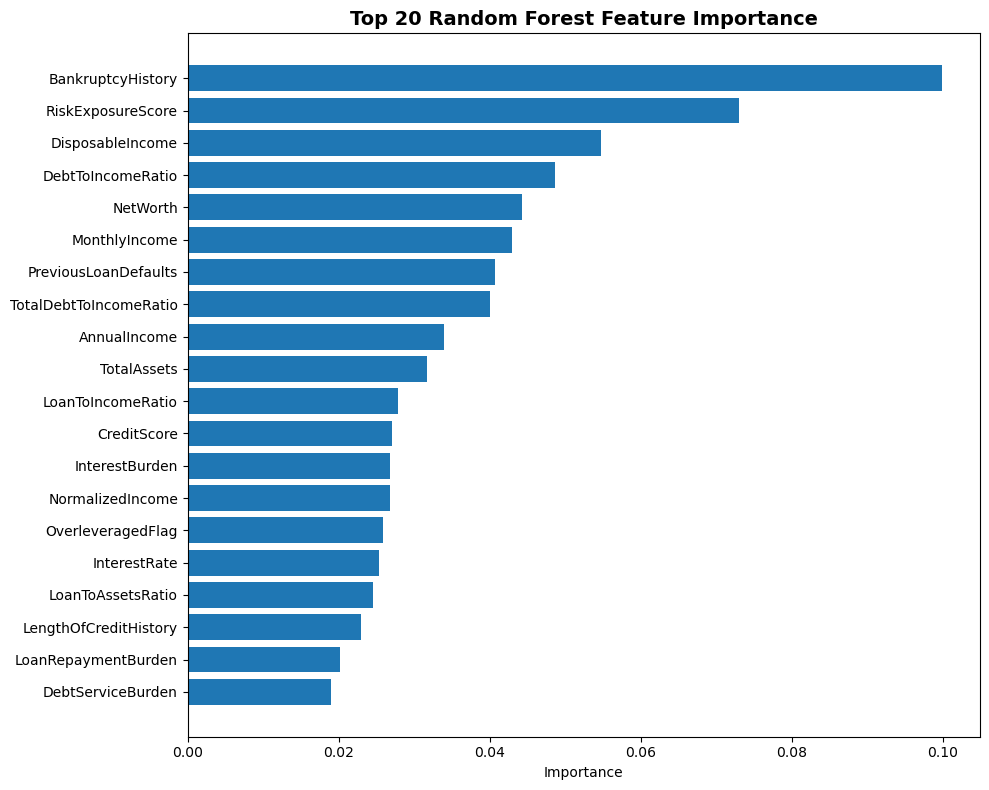

In [8]:
print("Training Random Forest Regressor...")
# Smaller hyperparameter grid centered around previously found best params
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

rf = RandomForestRegressor(random_state=R_seed, n_jobs=-1)
rf_grid = GridSearchCV(
    rf, 
    rf_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV RMSE: {-rf_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
rf_cv = rf_grid.best_estimator_
rf_cv_metrics = evaluate_model(
    rf_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'Random Forest (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
rf_best = RandomForestRegressor(**rf_grid.best_params_, random_state=R_seed, n_jobs=-1)
rf_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
rf_metrics = evaluate_model(
    rf_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'Random Forest'

)
all_results.append(rf_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/random_forest_best.pkl', 'wb') as f:
    pickle.dump(rf_best, f)
with open('../models/random_forest_gridsearch.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)
print("✓ Random Forest model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'], rf_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Random Forest Feature Importance', fontsize=14, fontweight='bold')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

---
# Model 5: XGBoost

Training XGBoost Regressor...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 600, 'subsample': 0.7}
Best CV RMSE: 2.2357

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

XGBoost (CV) - Performance Metrics
Training Set:
  RMSE: 1.2951
  MAE:  0.8368
  R²:   0.9721

Test Set:
  RMSE: 2.2368
  MAE:  1.4261
  R²:   0.9194

--- Retraining on full training data ---

XGBoost - Performance Metrics
Training Set:
  RMSE: 1.2951
  MAE:  0.8368
  R²:   0.9721

Test Set:
  RMSE: 2.2368
  MAE:  1.4261
  R²:   0.9194
✓ XGBoost model saved


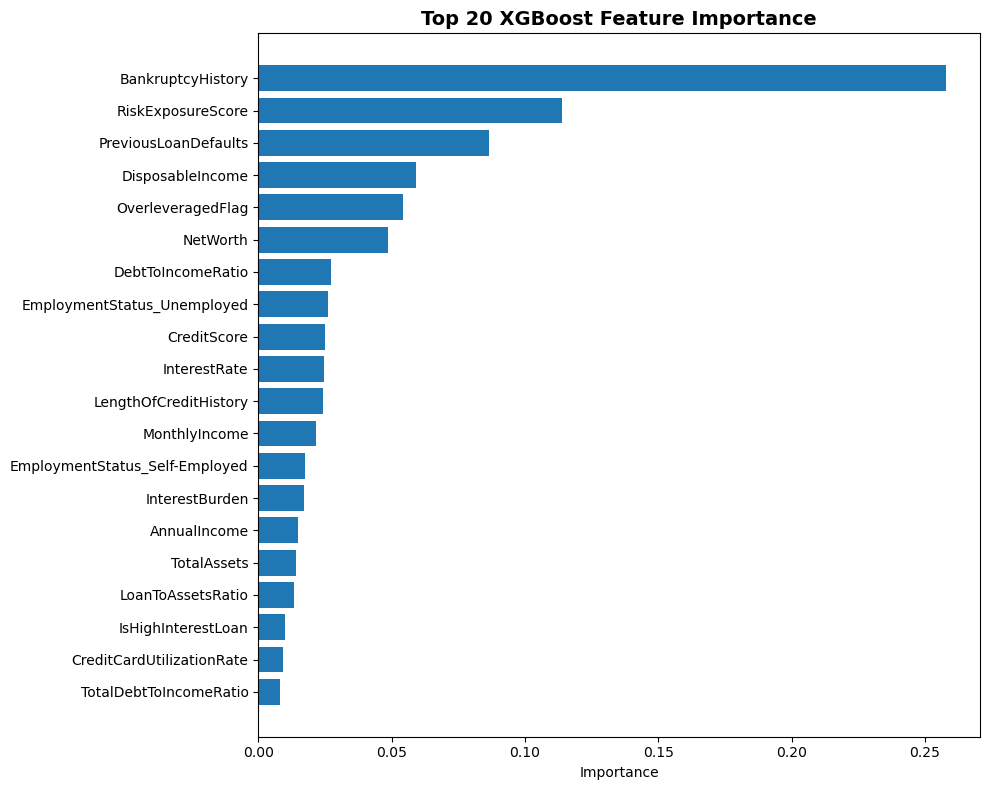

In [9]:
print("Training XGBoost Regressor...")

# Smaller hyperparameter grid centered around previously found best params
xgb_params = {
    'n_estimators': [400, 500, 600],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [4, 5, 6],
    'gamma': [0.1, 0.2]
}

xgb_model = xgb.XGBRegressor(
    random_state=R_seed,
    n_jobs=-1,
    tree_method='hist'
)

xgb_grid = GridSearchCV(
    xgb_model, 
    xgb_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV RMSE: {-xgb_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
xgb_cv = xgb_grid.best_estimator_
xgb_cv_metrics = evaluate_model(
    xgb_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'XGBoost (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
xgb_best = xgb.XGBRegressor(**xgb_grid.best_params_, random_state=R_seed, n_jobs=-1, tree_method='hist')
xgb_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
xgb_metrics = evaluate_model(
    xgb_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'XGBoost'

)
all_results.append(xgb_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/xgboost_best.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)
with open('../models/xgboost_gridsearch.pkl', 'wb') as f:
    pickle.dump(xgb_grid, f)
print("✓ XGBoost model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 XGBoost Feature Importance', fontsize=14, fontweight='bold')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

---
# Model 6: LightGBM

Training LightGBM Regressor...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV RMSE: 2.2210

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

LightGBM (CV) - Performance Metrics
Training Set:
  RMSE: 0.7020
  MAE:  0.4729
  R²:   0.9918

Test Set:
  RMSE: 2.2358
  MAE:  1.3725
  R²:   0.9195

--- Retraining on full training data ---

LightGBM - Performance Metrics
Training Set:
  RMSE: 0.7020
  MAE:  0.4729
  R²:   0.9918

Test Set:
  RMSE: 2.2358
  MAE:  1.3725
  R²:   0.9195
✓ LightGBM model saved


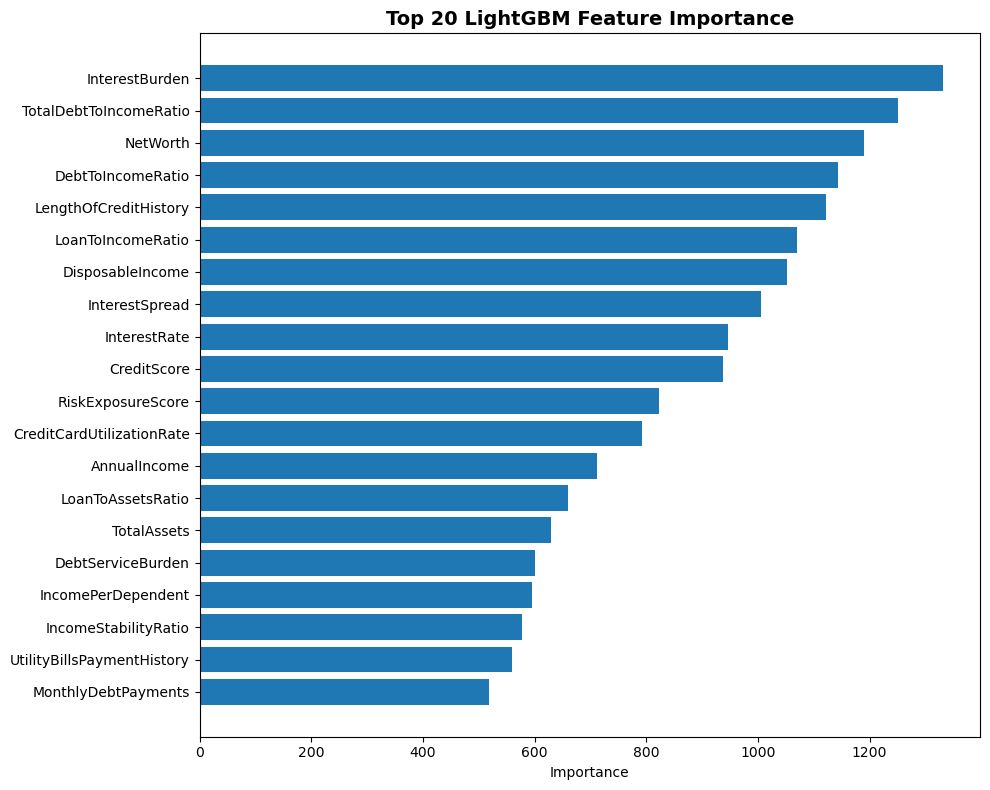

In [10]:
print("Training LightGBM Regressor...")

# Reduced hyperparameter grid for overnight completion
lgb_params = {
    'n_estimators': [300, 500],
    'max_depth': [7, -1],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_samples': [20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1]
}

lgb_model = lgb.LGBMRegressor(
    random_state=R_seed,
    n_jobs=-1,
    verbose=-1
)

lgb_grid = GridSearchCV(
    lgb_model, 
    lgb_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

lgb_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {lgb_grid.best_params_}")
print(f"Best CV RMSE: {-lgb_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
lgb_cv = lgb_grid.best_estimator_
lgb_cv_metrics = evaluate_model(
    lgb_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'LightGBM (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
lgb_best = lgb.LGBMRegressor(**lgb_grid.best_params_, random_state=R_seed, n_jobs=-1, verbose=-1)
lgb_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
lgb_metrics = evaluate_model(
    lgb_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'LightGBM'

)
all_results.append(lgb_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/lightgbm_best.pkl', 'wb') as f:
    pickle.dump(lgb_best, f)
with open('../models/lightgbm_gridsearch.pkl', 'wb') as f:
    pickle.dump(lgb_grid, f)
print("✓ LightGBM model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

lgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(lgb_importance['Feature'], lgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---
# Model 7: CatBoost

Training CatBoost Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.05, random_strength=1; total time=  11.1s
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.05, random_strength=1; total time=  10.6s
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.05, random_strength=1; total time=  10.6s
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.05, random_strength=1; total time=  10.7s
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.05, random_strength=1; total time=  10.6s
[CV] END bagging_temperature=0.5, border_count=128, depth=6, iterations=300, l2_leaf_reg=3, learning_rate=0.1, random_strength=1; total time=  10.5s
[CV] END b

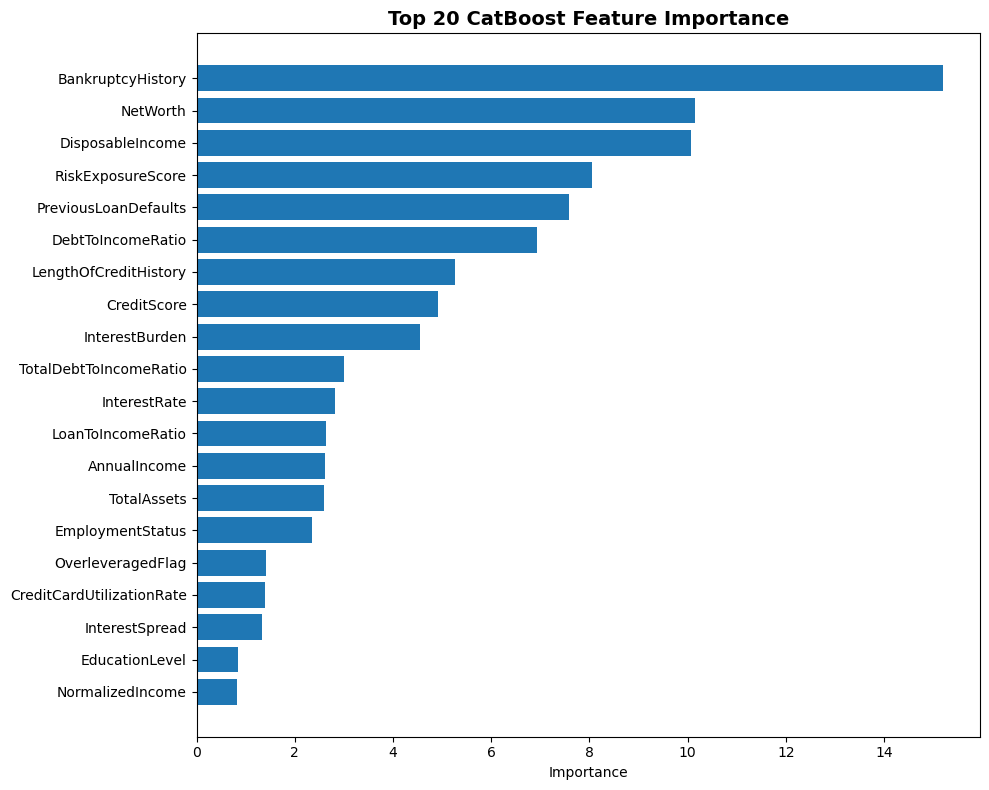

In [11]:
print("Training CatBoost Regressor...")

# Reduced hyperparameter grid for overnight completion
catboost_params = {
    'iterations': [300, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3],
    'border_count': [128],
    'bagging_temperature': [0.5],
    'random_strength': [1]
}

catboost_model = CatBoostRegressor(
    random_state=R_seed,
    verbose=0,
    thread_count=-1,
    cat_features=cat_features_idx
)

catboost_grid = GridSearchCV(
    catboost_model, 
    catboost_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # CatBoost handles parallelization internally
    verbose=2
)

catboost_grid.fit(X_train_catboost, y_train_catboost)

print(f"\nBest parameters: {catboost_grid.best_params_}")
print(f"Best CV RMSE: {-catboost_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
catboost_cv = catboost_grid.best_estimator_
catboost_cv_metrics = evaluate_model(
    catboost_cv, 
    X_train_catboost, y_train_catboost, 
    X_test_catboost, y_test_catboost,
    'CatBoost (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
catboost_best = CatBoostRegressor(**catboost_grid.best_params_, random_state=R_seed, verbose=0, thread_count=-1, cat_features=cat_features_idx)
catboost_best.fit(X_train_catboost, y_train_catboost)

# Evaluate full retrained model
catboost_metrics = evaluate_model(
    catboost_best, 
    X_train_catboost, y_train_catboost, 
    X_test_catboost, y_test_catboost,
    'CatBoost'

)
all_results.append(catboost_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/catboost_best.pkl', 'wb') as f:
    pickle.dump(catboost_best, f)
with open('../models/catboost_gridsearch.pkl', 'wb') as f:
    pickle.dump(catboost_grid, f)
print("✓ CatBoost model saved")

# Feature importance
feature_names = data_catboost['feature_names'] if 'feature_names' in data_catboost else [f'Feature_{i}' for i in range(X_train_catboost.shape[1])]

catboost_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': catboost_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(catboost_importance['Feature'], catboost_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


___
## Model 8: Convolutional Neural Network (CNN)

In [24]:
# 2 setup

# Build CNN architecture function
def build_cnn_model(input_dim, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    """
    Build 1D CNN model for regression
    """
    input_shape = (input_dim, 1)
    model = models.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.GlobalMaxPooling1D(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Convert data to proper numpy arrays with float32 dtype
print("Preparing CNN data...")
print(f"Original dtypes - X_train_tree: {X_train_tree.dtype}, y_train_tree: {y_train_tree.dtype}")

# Convert to float32 arrays (handles both numpy and pandas)
X_train_np = np.asarray(X_train_tree, dtype=np.float32)
X_test_np = np.asarray(X_test_tree, dtype=np.float32)
y_train_np = np.asarray(y_train_tree, dtype=np.float32)
y_test_np = np.asarray(y_test_tree, dtype=np.float32)

# Reshape data for CNN
X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

# Flatten target if needed
y_train_cnn = y_train_np.flatten()
y_test_cnn = y_test_np.flatten()

print("CNN architecture function defined!")
print(f"Data shapes: X_train_cnn={X_train_cnn.shape}, y_train_cnn={y_train_cnn.shape}")
print(f"Data dtypes: X_train_cnn={X_train_cnn.dtype}, y_train_cnn={y_train_cnn.dtype}")

Preparing CNN data...
Original dtypes - X_train_tree: object, y_train_tree: float64
CNN architecture function defined!
Data shapes: X_train_cnn=(16000, 75, 1), y_train_cnn=(16000,)
Data dtypes: X_train_cnn=float32, y_train_cnn=float32


In [25]:
# 3 Manual hyperparameter search (simplified for faster execution)
print("Training CNN with Manual Hyperparameter Search...")

# Reduced parameter combinations for overnight completion
cnn_params = [
    {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32},
    {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
]

print(f"\nTesting {len(cnn_params)} parameter combinations")

best_val_loss = float('inf')
best_params = None
best_model = None
cv_results = []

# Manual cross-validation
for param_idx, params in enumerate(cnn_params):
    print(f"\n{'='*80}")
    print(f"Testing Configuration {param_idx + 1}/{len(cnn_params)}")
    print(f"Parameters: {params}")
    print(f"{'='*80}")
    
    fold_losses = []
    
    # Perform k-fold CV manually
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train_cnn)):
        print(f"\nFold {fold_idx + 1}/{N_FOLDS}...")
        
        # Split data - ensure proper numpy arrays
        X_fold_train, X_fold_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_fold_train, y_fold_val = y_train_cnn[train_idx], y_train_cnn[val_idx]
        
        # Build and train model
        model = build_cnn_model(
            input_dim=X_train_tree.shape[1],
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Training callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
        
        # Train
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=50,  # Reduced for speed
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Get best validation loss
        val_loss = min(history.history['val_loss'])
        fold_losses.append(val_loss)
        print(f"  Fold {fold_idx + 1} val_loss: {val_loss:.4f}")
    
    # Calculate mean validation loss across folds
    mean_val_loss = np.mean(fold_losses)
    std_val_loss = np.std(fold_losses)
    
    cv_results.append({
        'params': params,
        'mean_val_loss': mean_val_loss,
        'std_val_loss': std_val_loss,
        'fold_losses': fold_losses
    })
    
    print(f"\nMean Validation Loss: {mean_val_loss:.4f} (+/- {std_val_loss:.4f})")
    print(f"Mean Validation RMSE: {np.sqrt(mean_val_loss):.4f}")
    
    # Update best params if this is better
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_params = params
        print("  ✓ New best configuration!")

print("\n" + "="*80)
print("CNN Manual Search Results:")
print("="*80)
print(f"Best parameters: {best_params}")
print(f"Best CV RMSE: {np.sqrt(best_val_loss):.4f}")
print(f"Best CV MSE: {best_val_loss:.4f}")

Training CNN with Manual Hyperparameter Search...

Testing 2 parameter combinations

Testing Configuration 1/2
Parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}

Fold 1/5...
  Fold 1 val_loss: 243.6260

Fold 2/5...
  Fold 2 val_loss: 80.0161

Fold 3/5...
  Fold 3 val_loss: 341.4494

Fold 4/5...
  Fold 4 val_loss: 131.5865

Fold 5/5...
  Fold 5 val_loss: 219.6865

Mean Validation Loss: 203.2729 (+/- 90.9084)
Mean Validation RMSE: 14.2574
  ✓ New best configuration!

Testing Configuration 2/2
Parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}

Fold 1/5...
  Fold 1 val_loss: 120.9853

Fold 2/5...
  Fold 2 val_loss: 115.8373

Fold 3/5...
  Fold 3 val_loss: 130.6202

Fold 4/5...
  Fold 4 val_loss: 122.0912

Fold 5/5...
  Fold 5 val_loss: 135.5064

Mean Validation Loss: 125.0081 (+/- 7.0782)
Mean Validation RMSE: 11.1807
  ✓ New best configuration!

CNN Manual Search Results:


In [26]:
# 4 Display detailed CV results
print("\n" + "="*80)
print("Detailed Cross-Validation Results:")
print("="*80)

for idx, result in enumerate(cv_results):
    print(f"\nConfiguration {idx + 1}:")
    print(f"  Parameters: {result['params']}")
    print(f"  Mean Val Loss: {result['mean_val_loss']:.4f} (+/- {result['std_val_loss']:.4f})")
    print(f"  Mean Val RMSE: {np.sqrt(result['mean_val_loss']):.4f}")
    print(f"  Fold losses: {[f'{loss:.4f}' for loss in result['fold_losses']]}")


Detailed Cross-Validation Results:

Configuration 1:
  Parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
  Mean Val Loss: 203.2729 (+/- 90.9084)
  Mean Val RMSE: 14.2574
  Fold losses: ['243.6260', '80.0161', '341.4494', '131.5865', '219.6865']

Configuration 2:
  Parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
  Mean Val Loss: 125.0081 (+/- 7.0782)
  Mean Val RMSE: 11.1807
  Fold losses: ['120.9853', '115.8373', '130.6202', '122.0912', '135.5064']


In [27]:
# 5 training of full dataset
print("\n" + "="*80)
print("Training CNN on Full Training Dataset")
print("="*80)

print(f"Using best parameters: {best_params}")

# Build final model with best parameters
cnn_best = build_cnn_model(
    input_dim=X_train_tree.shape[1],
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

print("\nCNN Architecture:")
print("="*80)
cnn_best.summary()
print("="*80)

# Training callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train on full training data
print("\nTraining on full training dataset...")
batch_size = best_params['batch_size']

history = cnn_best.fit(
    X_train_cnn, y_train_cnn,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ CNN training on full dataset complete!")
print(f"Training stopped at epoch: {len(history.history['loss'])}")


Training CNN on Full Training Dataset
Using best parameters: {'filters': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}

CNN Architecture:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 73, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 73, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 71, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 71, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 71, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_15         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,561 (197.50 KB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 384 (1.50 KB)


Training on full training dataset...
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 158.0210 - mae: 9.3424 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 89.4383 - mae: 7.5961 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 88.5112 - mae: 7.5139 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 85.6111 - mae: 7.3956 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 82.9045 - mae: 7.2620 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 81.4879 - mae: 7.1799 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 81.1941 - mae: 7.1782 - learning_rate: 0.0010
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 79.9211 - mae: 7.1376 - learning_rate: 0.0010
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 78.3433 - mae: 7.0821 - learning_ra

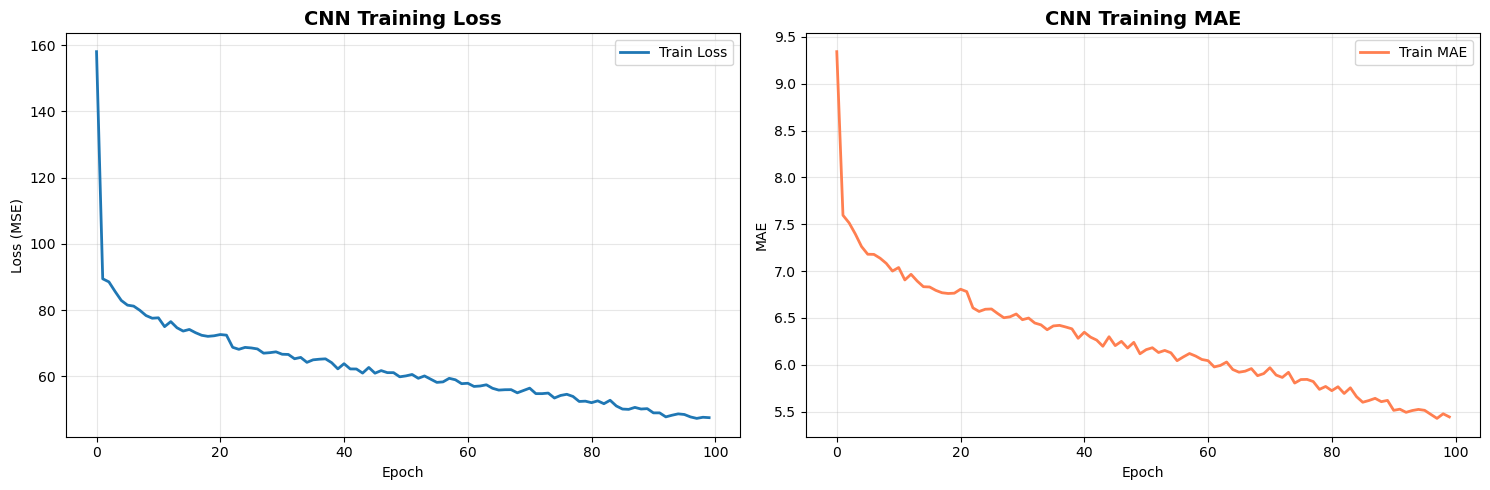

In [28]:
# 6 Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].set_title('CNN Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2, color='coral')
axes[1].set_title('CNN Training MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 7 Evaluate CNN trained on full dataset
print("\nEvaluating CNN model trained on full dataset...")

# Create wrapper for evaluation
class CNNWrapper:
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # Dummy fit method for sklearn compatibility
        return self
    
    def predict(self, X):
        # Convert to float32 numpy array first
        X = np.asarray(X, dtype=np.float32)
        # Reshape if needed
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], X.shape[1], 1)
        predictions = self.model.predict(X, verbose=0)
        # Flatten predictions
        if hasattr(predictions, 'flatten'):
            return predictions.flatten()
        return predictions
    
    def score(self, X, y):
        # R² score for sklearn compatibility
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

cnn_best_wrapper = CNNWrapper(cnn_best)

cnn_metrics = evaluate_model(
    cnn_best_wrapper,
    X_train_np, y_train_np,
    X_test_np, y_test_np,
    '1D CNN'
)

print("\n" + "="*80)
print("CNN Model Performance:")
print("="*80)

for metric, value in cnn_metrics.items():all_results.append(cnn_metrics)
    print(f"{metric}: {value}")# Add to results


IndentationError: unexpected indent (20232480.py, line 45)

In [37]:
# 8 saving CNN model and results
print("\nSaving CNN model...")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained model
cnn_best.save('../models/cnn_model.h5')
print("✓ CNN model saved to: ../models/cnn_model.h5")

# Save manual search results
with open('../models/cnn_search_results.pkl', 'wb') as f:
    pickle.dump({
        'best_params': best_params,
        'best_val_loss': best_val_loss,
        'cv_results': cv_results
    }, f)
print("✓ CNN search results saved to: ../models/cnn_search_results.pkl")

# Save training history
with open('../models/cnn_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ CNN training history saved to: ../models/cnn_history.pkl")

print("\n" + "="*80)


Saving CNN model...
✓ CNN model saved to: ../models/cnn_model.h5
✓ CNN search results saved to: ../models/cnn_search_results.pkl
✓ CNN training history saved to: ../models/cnn_history.pkl




Calculating CNN Feature Importance...
(Using permutation importance - this may take a moment)


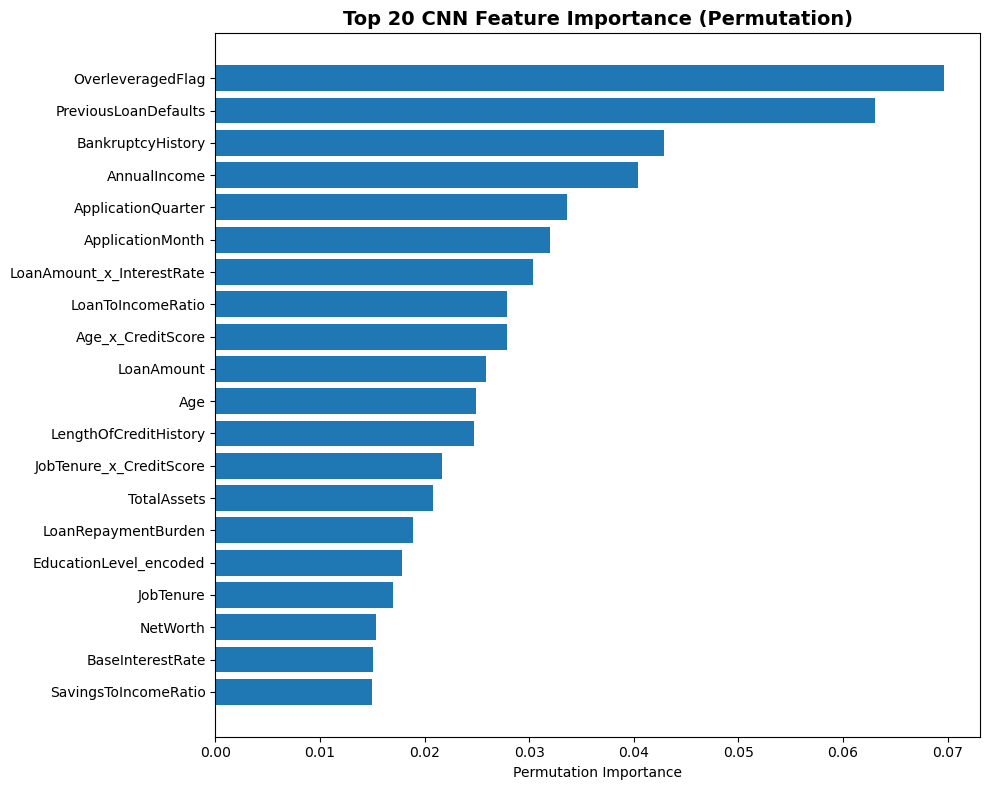


✓ CNN feature importance analysis complete!


In [38]:
# 9 CNN Feature Importance using Permutation Importance
print("\nCalculating CNN Feature Importance...")
print("(Using permutation importance - this may take a moment)")

from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    cnn_best_wrapper,
    X_test_np,
    y_test_np,
    scoring='r2',
    n_repeats=10,
    random_state=R_seed,
    n_jobs=-1
)

# Create importance dataframe
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_np.shape[1])]

cnn_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False).head(20)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cnn_importance['Feature'], cnn_importance['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 CNN Feature Importance (Permutation)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ CNN feature importance analysis complete!")

---
## Model Comparison

In [39]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)


COMPREHENSIVE MODEL COMPARISON
           Model   Train_RMSE    Train_MAE  Train_R2  Test_RMSE  Test_MAE  Test_R2
Ridge Regression 3.433221e+00 2.690690e+00  0.803784   3.650724  2.810569 0.785339
Lasso Regression 3.433746e+00 2.690347e+00  0.803724   3.648661  2.808283 0.785581
      ElasticNet 3.433802e+00 2.690347e+00  0.803718   3.648603  2.808204 0.785588
   Random Forest 8.065683e-14 3.323075e-14  1.000000   3.252711  2.285984 0.829593
         XGBoost 1.295068e+00 8.368257e-01  0.972080   2.236801  1.426102 0.919416
        LightGBM 7.019552e-01 4.729456e-01  0.991797   2.235761  1.372521 0.919491
        CatBoost 1.640746e+00 1.081199e+00  0.955186   2.222694  1.450500 0.920429
          1D CNN 6.175370e+00 4.983476e+00  0.365171   6.350435  5.154298 0.350464
          1D CNN 6.175370e+00 4.983476e+00  0.365171   6.350435  5.154298 0.350464


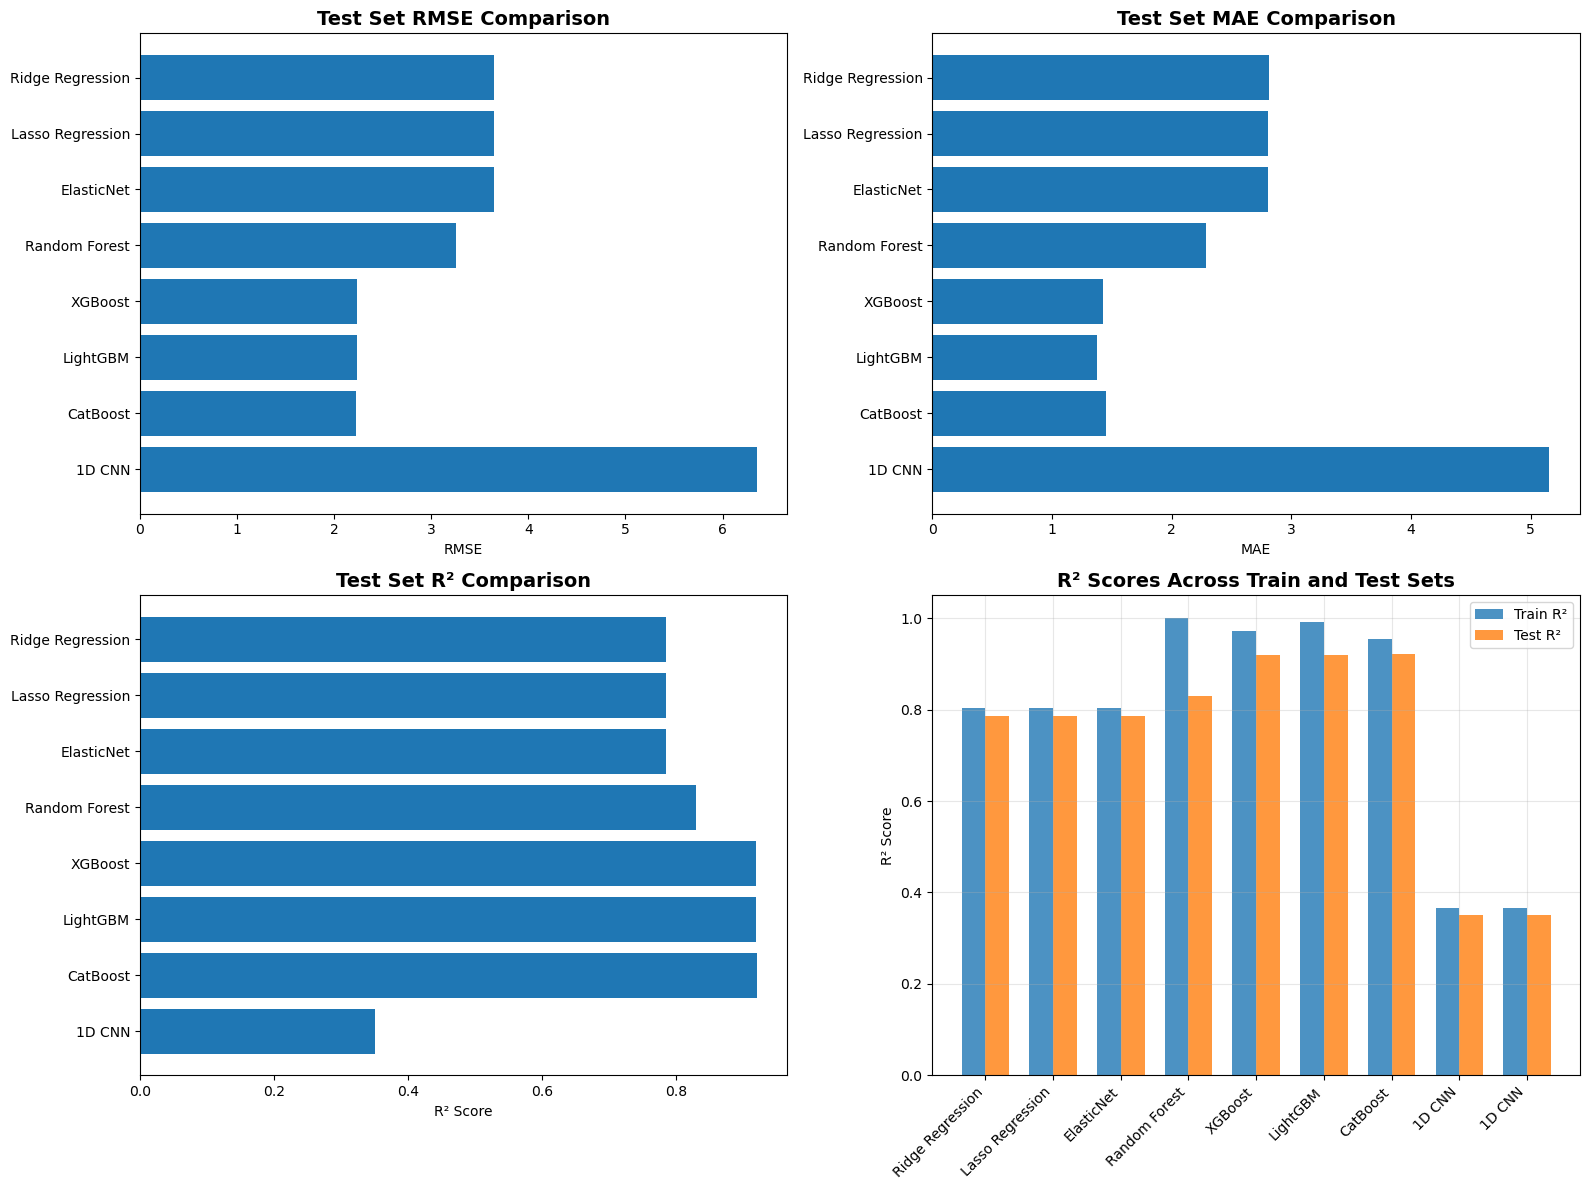

In [40]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE
axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test Set RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Test MAE
axes[0, 1].barh(results_df['Model'], results_df['Test_MAE'])
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Test Set MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Test R²
axes[1, 0].barh(results_df['Model'], results_df['Test_R2'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Test Set R² Comparison', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# All metrics comparison
x = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.8)
axes[1, 1].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.8)
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('R² Scores Across Train and Test Sets', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()